In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3
import sys
sys.path.append('..')

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import processed data

In [13]:
df_data = pd.read_csv(os.path.join(DATA_PATH,'model_data.csv'))

## Missing values

In [14]:
from scripts.preprocess import missing_data_V1

df_preproc = missing_data_V1(df_data)


Missing Data Removal Summary:
--------------------------------------------------
Initial number of rows: 86752

Step 1: Wind/Solar Data
-------------------------
Total rows removed: 5,193
Rows remaining: 81,559

Step 2: Price Data
-------------------------
Rows removed: 0
Rows remaining: 81,559

Step 3: Load Data
-------------------------
Rows removed: 287
Final number of rows: 81,272

Total rows removed: 5,480
Percentage of data retained: 93.7%


## Remove outliers

In [15]:
from scripts.preprocess import remove_outliers_V1

df_preproc = remove_outliers_V1(df_preproc)


Total rows removed: 3
Percentage of data retained: 100.0%


## Feature engineering

In [16]:
from scripts.preprocess import feature_engineering

df_preproc = feature_engineering(df_preproc)

Adding cyclical time features...
Converting datetime to index...
Creating cyclical features...
Feature engineering completed!


## Merge with fuel prices

In [17]:
from scripts.preprocess import merge_fuel_prices

df_preproc = merge_fuel_prices(df_preproc)


Processing fuel and carbon prices...
Loading EUA carbon prices...
Loading TTF gas prices...
Loading ARA coal prices...
Loading USD/EUR exchange rates...
Merging price datasets...
Converting coal prices to EUR...
Processing dates for monthly merging...
Saving processed fuel prices to: /home/ronan/code/Power_Price_Forecasting/data/fuel_prices.csv
Merging with main dataset...
Fuel price merging completed!


## Plot prices

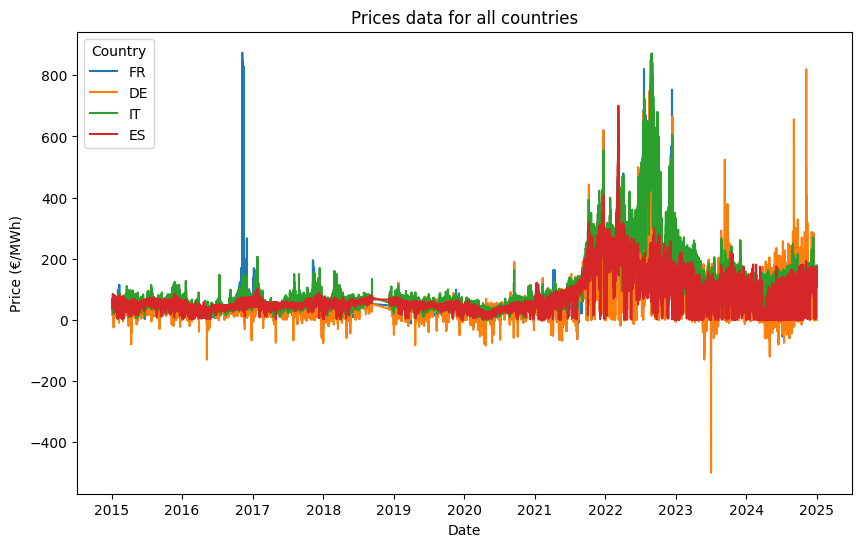

In [18]:
# Plot prices data for all countries

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df_preproc, x='datetime', y='FR_price', ax=ax, label='FR')
sns.lineplot(data=df_preproc, x='datetime', y='DE_price', ax=ax, label='DE')
sns.lineplot(data=df_preproc, x='datetime', y='IT_price', ax=ax, label='IT')
sns.lineplot(data=df_preproc, x='datetime', y='ES_price', ax=ax, label='ES')

ax.set_title('Prices data for all countries')
ax.set_xlabel('Date')
ax.set_ylabel('Price (€/MWh)')
ax.legend(title='Country')
plt.show()


In [19]:
from scripts.preprocess import create_features_V1

df_preproc = create_features_V1(df_preproc, lag_hours = 24*3)

df_preproc.info()

Final dataset shape: (68864, 84)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68864 entries, 2015-01-09 00:00:00+01:00 to 2024-12-31 23:00:00+01:00
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FR_Solar          68864 non-null  float64
 1   FR_Wind Offshore  68864 non-null  float64
 2   FR_Wind Onshore   68864 non-null  float64
 3   FR_forecast_load  68864 non-null  float64
 4   FR_price          68864 non-null  float64
 5   Day_sin           68864 non-null  float64
 6   Day_cos           68864 non-null  float64
 7   Year_sin          68864 non-null  float64
 8   Year_cos          68864 non-null  float64
 9   EUA_EUR           68864 non-null  float64
 10  TTF_EUR           68864 non-null  float64
 11  ARA_EUR           68864 non-null  float64
 12  price_lag_25h     68864 non-null  float64
 13  price_lag_26h     68864 non-null  float64
 14  price_lag_27h     68864 non-null  float64
 15  price_l

## Split train test

### For now we do not care about the chronology

In [ ]:
X = df_preproc.drop(columns=['FR_price'])
y = df_preproc['FR_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
pipe = Pipeline([
    ('imputer_zero', SimpleImputer(fill_value=0)),
    ('stdscaler', StandardScaler())]
    ).set_output(transform='pandas')

excluded = ['Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']
selected_columns = [col for col in X_train.columns if col not in excluded]

preproc_pipeline = ColumnTransformer([('base_pipeline', pipe, selected_columns)], remainder='passthrough').set_output(transform='pandas')

preproc_pipeline

,transformers,"[('base_pipeline', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,0


In [22]:
X_train_preproc = preproc_pipeline.fit_transform(X_train)

X_train_preproc

,base_pipeline__FR_Solar,base_pipeline__FR_Wind Offshore,base_pipeline__FR_Wind Onshore,base_pipeline__FR_forecast_load,base_pipeline__EUA_EUR,base_pipeline__TTF_EUR,base_pipeline__ARA_EUR,base_pipeline__price_lag_25h,base_pipeline__price_lag_26h,base_pipeline__price_lag_27h,...,base_pipeline__price_lag_91h,base_pipeline__price_lag_92h,base_pipeline__price_lag_93h,base_pipeline__price_lag_94h,base_pipeline__price_lag_95h,base_pipeline__price_lag_96h,remainder__Day_sin,remainder__Day_cos,remainder__Year_sin,remainder__Year_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-23 07:00:00+02:00,-0.637849,-0.304640,-0.738657,-0.372866,0.619994,0.687956,1.370120,1.318516,1.062747,0.613851,...,1.259855,1.257457,1.420444,1.573746,1.649652,1.440055,9.659258e-01,2.588190e-01,-0.929812,0.368035
2016-06-04 21:00:00+02:00,-0.596475,-0.304640,-0.895825,-1.040813,-1.081066,-0.565697,-0.684354,-0.529206,-0.511343,-0.530352,...,-0.644771,-0.632257,-0.613415,-0.567219,-0.541887,-0.529768,-9.659258e-01,2.588190e-01,0.447716,-0.894176
2024-06-09 10:00:00+02:00,1.562532,1.179259,-0.528128,-1.307146,0.891273,-0.066486,0.036365,-0.735141,-0.637644,-0.735348,...,-0.869504,-0.869444,-0.853609,-0.868699,-0.832076,-0.825156,8.660254e-01,-5.000000e-01,0.375604,-0.926780
2018-02-18 16:00:00+01:00,-0.115900,-0.304640,-0.631290,0.299308,-0.904500,-0.491827,-0.447610,-0.480301,-0.476575,-0.427318,...,-0.471022,-0.412027,-0.322879,-0.313942,-0.381883,-0.420203,-7.071068e-01,-7.071068e-01,0.746428,0.665466
2015-12-04 05:00:00+01:00,-0.637849,-0.304640,0.262567,0.269716,-0.961264,-0.555492,-0.755745,-0.551132,-0.559953,-0.511375,...,-0.381748,-0.365741,-0.344957,-0.365024,-0.428591,-0.647688,8.660254e-01,5.000000e-01,-0.463089,0.886312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-26 07:00:00+01:00,-0.637849,-0.304640,-0.204412,0.193620,-0.985099,-0.418479,-0.296963,-0.368950,-0.466381,-0.464093,...,-0.176214,-0.145831,-0.128015,-0.102789,-0.103665,-0.113355,1.000000e+00,-3.704860e-13,-0.571889,0.820331
2021-12-25 13:00:00+01:00,0.373825,-0.304640,-0.771966,0.354266,1.308070,0.824000,0.281132,2.936871,2.839755,3.131270,...,5.531158,5.742903,4.889172,4.517519,4.219024,4.054419,2.130119e-13,-1.000000e+00,-0.104916,0.994481
2021-07-26 03:00:00+02:00,-0.637849,-0.304640,-0.450514,-1.518521,0.451268,0.089349,0.166481,-0.285114,-0.187061,-0.148236,...,0.253092,0.237359,0.144496,-0.036457,-0.078654,-0.068908,2.588190e-01,9.659258e-01,-0.402070,-0.915609


# 2. Forecast with XGBoost

## First model

In [23]:
xgb_reg = XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1)

xgb_pipe = make_pipeline(preproc_pipeline, xgb_reg, memory=cachedir)

# Cross-validate using the MSE scorer
xgb_score = cross_val_score(
    xgb_pipe, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1).mean()

np.sqrt(-xgb_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


np.float64(18.97317807939486)

## Hyperparameters tuning

In [24]:
xgb_pipe.get_params()

{'memory': '/tmp/tmpqrnlm18l',
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('base_pipeline',
                                    Pipeline(steps=[('imputer_zero',
                                                     SimpleImputer(fill_value=0)),
                                                    ('stdscaler',
                                                     StandardScaler())]),
                                    ['FR_Solar', 'FR_Wind Offshore',
                                     'FR_Wind Onshore', 'FR_forecast_load',
                                     'EUA_EUR', 'TTF_EUR', 'ARA_EUR',
                                     'price_lag_25h', 'price_lag_26h',
                                     'price_lag_27h', 'price_lag_28h',
                                     'price_lag_29h', 'price_lag_30h',
                                     'price_lag_31h', 'price_lag_32h',
                                     'price_la

In [25]:
def objective(trial, X, y, pipeline):
    # Define the hyperparameter search space
    params = {
        'xgbregressor__max_depth': trial.suggest_int('xgbregressor__max_depth', 3, 10),
        'xgbregressor__learning_rate': trial.suggest_float('xgbregressor__learning_rate', 0.01, 0.3, log=True),
        'xgbregressor__n_estimators': trial.suggest_int('xgbregressor__n_estimators', 100, 1000),
        'xgbregressor__min_child_weight': trial.suggest_int('xgbregressor__min_child_weight', 1, 7),
        'xgbregressor__subsample': trial.suggest_float('xgbregressor__subsample', 0.6, 1.0),
        'xgbregressor__colsample_bytree': trial.suggest_float('xgbregressor__colsample_bytree', 0.6, 1.0),
        'xgbregressor__gamma': trial.suggest_float('xgbregressor__gamma', 0, 5),
        'xgbregressor__reg_alpha': trial.suggest_float('xgbregressor__reg_alpha', 0, 5),
        'xgbregressor__reg_lambda': trial.suggest_float('xgbregressor__reg_lambda', 0, 5)
    }
    
    # Set the parameters in the pipeline
    pipeline.set_params(**params)
    print(pipeline)
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        pipeline,
        X,
        y,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    return np.mean(cv_scores)

In [26]:
study = optuna.create_study(direction='maximize',study_name='xgb_optim', sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(lambda trial: objective(trial, X_train, y_train, xgb_pipe), n_trials=20)
best_params = study.best_params

[I 2025-08-12 15:44:38,489] A new study created in memory with name: xgb_optim


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:45:06,943] Trial 0 finished with value: -202.62506875070144 and parameters: {'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.11387317092169064, 'xgbregressor__n_estimators': 643, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.7694619197355619, 'xgbregressor__colsample_bytree': 0.8583576452266624, 'xgbregressor__gamma': 2.1879360563134624, 'xgbregressor__reg_alpha': 4.4588650039103985, 'xgbregressor__reg_lambda': 4.818313802505147}. Best is trial 0 with value: -202.62506875070144.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:45:25,581] Trial 1 finished with value: -209.10919767383126 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1477317633429356, 'xgbregressor__n_estimators': 576, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.9702386553170644, 'xgbregressor__colsample_bytree': 0.6284144232791548, 'xgbregressor__gamma': 0.43564649850770354, 'xgbregressor__reg_alpha': 0.1010919872016286, 'xgbregressor__reg_lambda': 4.16309922773969}. Best is trial 0 with value: -202.62506875070144.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:46:24,344] Trial 2 finished with value: -244.229963886352 and parameters: {'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.19280284410033463, 'xgbregressor__n_estimators': 981, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.7845917449011728, 'xgbregressor__colsample_bytree': 0.9122116705145822, 'xgbregressor__gamma': 0.5913721293446661, 'xgbregressor__reg_alpha': 3.199605106637619, 'xgbregressor__reg_lambda': 0.716766437045232}. Best is trial 0 with value: -202.62506875070144.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:47:26,212] Trial 3 finished with value: -226.1967877270613 and parameters: {'xgbregressor__max_depth': 10, 'xgbregressor__learning_rate': 0.0589974509393851, 'xgbregressor__n_estimators': 473, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.9096934757736866, 'xgbregressor__colsample_bytree': 0.7824601328866194, 'xgbregressor__gamma': 2.8421697443432423, 'xgbregressor__reg_alpha': 0.09394900218177571, 'xgbregressor__reg_lambda': 3.0881774853793855}. Best is trial 0 with value: -202.62506875070144.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:48:00,672] Trial 4 finished with value: -195.6159461646473 and parameters: {'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.0815241575370242, 'xgbregressor__n_estimators': 950, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.7438031602295144, 'xgbregressor__colsample_bytree': 0.7748127815197365, 'xgbregressor__gamma': 3.4881559796363244, 'xgbregressor__reg_alpha': 0.30112735814634917, 'xgbregressor__reg_lambda': 3.3338335772283383}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:48:15,988] Trial 5 finished with value: -322.78286962151026 and parameters: {'xgbregressor__max_depth': 8, 'xgbregressor__learning_rate': 0.020453166444527108, 'xgbregressor__n_estimators': 216, 'xgbregressor__min_child_weight': 3, 'xgbregressor__subsample': 0.745484308377049, 'xgbregressor__colsample_bytree': 0.8280787081671519, 'xgbregressor__gamma': 2.193007567311602, 'xgbregressor__reg_alpha': 4.941869190296131, 'xgbregressor__reg_lambda': 0.5102240537401403}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:48:26,696] Trial 6 finished with value: -399.36786025892224 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.01730906932990894, 'xgbregressor__n_estimators': 688, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.7865243091425225, 'xgbregressor__colsample_bytree': 0.6977702368006411, 'xgbregressor__gamma': 0.7948479182275986, 'xgbregressor__reg_alpha': 0.5518757058215257, 'xgbregressor__reg_lambda': 3.281647947326367}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:48:34,271] Trial 7 finished with value: -437.4508479697436 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.019515333830126363, 'xgbregressor__n_estimators': 432, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.6388405103172244, 'xgbregressor__colsample_bytree': 0.9351779629995216, 'xgbregressor__gamma': 0.48049203946981534, 'xgbregressor__reg_alpha': 4.882297325066979, 'xgbregressor__reg_lambda': 2.343256008238508}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:49:59,413] Trial 8 finished with value: -226.43625459067843 and parameters: {'xgbregressor__max_depth': 10, 'xgbregressor__learning_rate': 0.07824023983213262, 'xgbregressor__n_estimators': 766, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.7131227850305638, 'xgbregressor__colsample_bytree': 0.6480786244852675, 'xgbregressor__gamma': 1.4807009876107247, 'xgbregressor__reg_alpha': 0.5936385947712203, 'xgbregressor__reg_lambda': 1.5899158969698801}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:50:19,507] Trial 9 finished with value: -313.5781717904779 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.012438088147597642, 'xgbregressor__n_estimators': 723, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.7061557963757782, 'xgbregressor__colsample_bytree': 0.8092992213866799, 'xgbregressor__gamma': 0.4697025537922084, 'xgbregressor__reg_alpha': 2.8797324777808964, 'xgbregressor__reg_lambda': 4.646480987881071}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:50:24,285] Trial 10 finished with value: -288.95789873089774 and parameters: {'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.09679346966037666, 'xgbregressor__n_estimators': 218, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.7157624371788804, 'xgbregressor__colsample_bytree': 0.6732765448028467, 'xgbregressor__gamma': 2.9325646740504157, 'xgbregressor__reg_alpha': 0.10053773093746776, 'xgbregressor__reg_lambda': 4.144700146086816}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:50:28,748] Trial 11 finished with value: -367.32215871409596 and parameters: {'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.1002806668544501, 'xgbregressor__n_estimators': 343, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.9848754180469753, 'xgbregressor__colsample_bytree': 0.6995012574079832, 'xgbregressor__gamma': 2.8807866720891844, 'xgbregressor__reg_alpha': 2.9602096563591953, 'xgbregressor__reg_lambda': 2.861259528954367}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:50:35,840] Trial 12 finished with value: -240.20766662312812 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.2554617102420103, 'xgbregressor__n_estimators': 502, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.8797917101270016, 'xgbregressor__colsample_bytree': 0.7189747803420534, 'xgbregressor__gamma': 4.068989098512386, 'xgbregressor__reg_alpha': 1.9825287042349231, 'xgbregressor__reg_lambda': 4.405515985555808}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:51:04,362] Trial 13 finished with value: -220.4254378388695 and parameters: {'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.2006457864626188, 'xgbregressor__n_estimators': 723, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.800529752770681, 'xgbregressor__colsample_bytree': 0.9824334538892896, 'xgbregressor__gamma': 3.219950996148187, 'xgbregressor__reg_alpha': 2.1192752427908985, 'xgbregressor__reg_lambda': 3.031966070639622}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:51:12,481] Trial 14 finished with value: -425.0597551031063 and parameters: {'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.02789090276380233, 'xgbregressor__n_estimators': 694, 'xgbregressor__min_child_weight': 3, 'xgbregressor__subsample': 0.8472061715995366, 'xgbregressor__colsample_bytree': 0.7715074803783064, 'xgbregressor__gamma': 0.6773703211122512, 'xgbregressor__reg_alpha': 1.4914116297801538, 'xgbregressor__reg_lambda': 2.8498245535063242}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:51:47,979] Trial 15 finished with value: -207.56335601283726 and parameters: {'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.07052580178322806, 'xgbregressor__n_estimators': 688, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.7725673741735896, 'xgbregressor__colsample_bytree': 0.9586186383404252, 'xgbregressor__gamma': 1.8378093502394828, 'xgbregressor__reg_alpha': 2.179324626328134, 'xgbregressor__reg_lambda': 4.45961677507836}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:52:07,211] Trial 16 finished with value: -239.93935149167837 and parameters: {'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.10957936709000932, 'xgbregressor__n_estimators': 190, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.8856965198196445, 'xgbregressor__colsample_bytree': 0.9995388026271466, 'xgbregressor__gamma': 0.7472415232899687, 'xgbregressor__reg_alpha': 4.340630286841071, 'xgbregressor__reg_lambda': 0.8124646733818741}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:52:50,356] Trial 17 finished with value: -247.0110474988043 and parameters: {'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.01523691793330935, 'xgbregressor__n_estimators': 864, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.8276402954458373, 'xgbregressor__colsample_bytree': 0.7628733188903999, 'xgbregressor__gamma': 0.34583497727569024, 'xgbregressor__reg_alpha': 3.4871438657228184, 'xgbregressor__reg_lambda': 2.2677134133903443}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:53:45,843] Trial 18 finished with value: -225.1774036866853 and parameters: {'xgbregressor__max_depth': 8, 'xgbregressor__learning_rate': 0.19043718286754036, 'xgbregressor__n_estimators': 978, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.6046856336740007, 'xgbregressor__colsample_bytree': 0.7439912257913456, 'xgbregressor__gamma': 3.64995281212029, 'xgbregressor__reg_alpha': 0.8581483863072026, 'xgbregressor__reg_lambda': 2.6051830310206463}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:53:49,158] Trial 19 finished with value: -941.3795298236412 and parameters: {'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.019743271501109723, 'xgbregressor__n_estimators': 116, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.689569875224152, 'xgbregressor__colsample_bytree': 0.7381406722787611, 'xgbregressor__gamma': 4.640406467327955, 'xgbregressor__reg_alpha': 3.5220720096176636, 'xgbregressor__reg_lambda': 0.15919464765653923}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:54:07,137] Trial 20 finished with value: -261.8409427211439 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.08279401738153831, 'xgbregressor__n_estimators': 620, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.9736855991699175, 'xgbregressor__colsample_bytree': 0.8455863823863584, 'xgbregressor__gamma': 2.6781640151247914, 'xgbregressor__reg_alpha': 2.949549881772855, 'xgbregressor__reg_lambda': 3.650610147583848}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:54:16,681] Trial 21 finished with value: -341.1708206592551 and parameters: {'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.03874545765516461, 'xgbregressor__n_estimators': 289, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.9777489559935735, 'xgbregressor__colsample_bytree': 0.8958203180197151, 'xgbregressor__gamma': 2.4522940430878353, 'xgbregressor__reg_alpha': 1.137073139866616, 'xgbregressor__reg_lambda': 1.2717824088519647}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:54:24,833] Trial 22 finished with value: -447.820738791993 and parameters: {'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.04382137808291109, 'xgbregressor__n_estimators': 380, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.7511007357169923, 'xgbregressor__colsample_bytree': 0.6718414710238539, 'xgbregressor__gamma': 0.12339364195665614, 'xgbregressor__reg_alpha': 0.3362481573162429, 'xgbregressor__reg_lambda': 3.3969638674928366}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:54:55,572] Trial 23 finished with value: -204.46973376774753 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.062028682613799783, 'xgbregressor__n_estimators': 907, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.6867587937593895, 'xgbregressor__colsample_bytree': 0.8652312812400402, 'xgbregressor__gamma': 1.3166118836857532, 'xgbregressor__reg_alpha': 0.1032549973286434, 'xgbregressor__reg_lambda': 3.791893269180707}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:55:12,655] Trial 24 finished with value: -273.41788360382054 and parameters: {'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.03684874222698003, 'xgbregressor__n_estimators': 630, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.8515927374364595, 'xgbregressor__colsample_bytree': 0.9490602621789581, 'xgbregressor__gamma': 1.3677101740781787, 'xgbregressor__reg_alpha': 3.9902341695628185, 'xgbregressor__reg_lambda': 0.928179721529761}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:55:42,933] Trial 25 finished with value: -233.61461049362606 and parameters: {'xgbregressor__max_depth': 10, 'xgbregressor__learning_rate': 0.10363430647263533, 'xgbregressor__n_estimators': 294, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.8923423227080631, 'xgbregressor__colsample_bytree': 0.7015766570380103, 'xgbregressor__gamma': 1.06655988683741, 'xgbregressor__reg_alpha': 2.5910035696533162, 'xgbregressor__reg_lambda': 0.12831359027265787}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:55:49,824] Trial 26 finished with value: -345.04854199266254 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.04239473573522302, 'xgbregressor__n_estimators': 437, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.7110514825178927, 'xgbregressor__colsample_bytree': 0.8347137385832675, 'xgbregressor__gamma': 4.319278029616157, 'xgbregressor__reg_alpha': 0.5876592798101654, 'xgbregressor__reg_lambda': 2.5868955357705707}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:55:56,715] Trial 27 finished with value: -268.12550665115066 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.11452193350965156, 'xgbregressor__n_estimators': 456, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.6733119344856314, 'xgbregressor__colsample_bytree': 0.6579391037373509, 'xgbregressor__gamma': 2.440281403244773, 'xgbregressor__reg_alpha': 1.778063689249778, 'xgbregressor__reg_lambda': 4.702159726264065}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:56:43,333] Trial 28 finished with value: -241.97002175290146 and parameters: {'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.12760478070837766, 'xgbregressor__n_estimators': 914, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.8208769879689626, 'xgbregressor__colsample_bytree': 0.8337904275823076, 'xgbregressor__gamma': 4.809681892736145, 'xgbregressor__reg_alpha': 1.4607376339627443, 'xgbregressor__reg_lambda': 1.2041438995772342}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:56:54,410] Trial 29 finished with value: -522.8744718174366 and parameters: {'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.010574712165212026, 'xgbregressor__n_estimators': 937, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.9140611648092551, 'xgbregressor__colsample_bytree': 0.7126920423015797, 'xgbregressor__gamma': 2.9320508309316335, 'xgbregressor__reg_alpha': 0.3197763306049056, 'xgbregressor__reg_lambda': 2.4281379796731146}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:57:28,695] Trial 30 finished with value: -234.99623045959424 and parameters: {'xgbregressor__max_depth': 10, 'xgbregressor__learning_rate': 0.1971081254611068, 'xgbregressor__n_estimators': 404, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.6926806505884818, 'xgbregressor__colsample_bytree': 0.9797275289662726, 'xgbregressor__gamma': 4.706888523532493, 'xgbregressor__reg_alpha': 3.9960129367619586, 'xgbregressor__reg_lambda': 3.1522396843339555}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:58:33,351] Trial 31 finished with value: -204.8506173303449 and parameters: {'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.02709109070162613, 'xgbregressor__n_estimators': 864, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.6052947431035598, 'xgbregressor__colsample_bytree': 0.7388934071728879, 'xgbregressor__gamma': 0.7407043047408252, 'xgbregressor__reg_alpha': 4.909146949091266, 'xgbregressor__reg_lambda': 2.3918515351999403}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:58:48,074] Trial 32 finished with value: -223.20842182155351 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.08801940851034674, 'xgbregressor__n_estimators': 432, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.9288470932776982, 'xgbregressor__colsample_bytree': 0.6759391647611032, 'xgbregressor__gamma': 2.55659491273228, 'xgbregressor__reg_alpha': 1.1215851448736962, 'xgbregressor__reg_lambda': 0.4892224224701702}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:59:27,636] Trial 33 finished with value: -259.4954381024907 and parameters: {'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.273602496851943, 'xgbregressor__n_estimators': 965, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.9096189330794555, 'xgbregressor__colsample_bytree': 0.7332580608114567, 'xgbregressor__gamma': 0.4055069499399838, 'xgbregressor__reg_alpha': 2.036205857069037, 'xgbregressor__reg_lambda': 1.1611707108547136}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:59:41,577] Trial 34 finished with value: -438.86432982229616 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.011992740205019881, 'xgbregressor__n_estimators': 753, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.9082322994011105, 'xgbregressor__colsample_bytree': 0.65877865816015, 'xgbregressor__gamma': 0.39761041293377875, 'xgbregressor__reg_alpha': 0.4480151711930269, 'xgbregressor__reg_lambda': 3.3602390367695723}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 15:59:55,675] Trial 35 finished with value: -317.99165653759985 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.04180110714707185, 'xgbregressor__n_estimators': 602, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.8908177050845313, 'xgbregressor__colsample_bytree': 0.7081311620954859, 'xgbregressor__gamma': 0.657413996455638, 'xgbregressor__reg_alpha': 0.2768716021059897, 'xgbregressor__reg_lambda': 1.5079931724047124}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:00:11,702] Trial 36 finished with value: -247.97694423917414 and parameters: {'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.047181845740641805, 'xgbregressor__n_estimators': 715, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.7134075386328667, 'xgbregressor__colsample_bytree': 0.7519707823600482, 'xgbregressor__gamma': 0.9057548086845152, 'xgbregressor__reg_alpha': 3.9427275615325934, 'xgbregressor__reg_lambda': 0.2842403821662015}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:01:05,629] Trial 37 finished with value: -218.12850347562807 and parameters: {'xgbregressor__max_depth': 8, 'xgbregressor__learning_rate': 0.14132777455071927, 'xgbregressor__n_estimators': 800, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.7495252551730246, 'xgbregressor__colsample_bytree': 0.8350398540785556, 'xgbregressor__gamma': 1.3641095121223352, 'xgbregressor__reg_alpha': 1.8542639960894436, 'xgbregressor__reg_lambda': 0.9852714009281982}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:01:34,182] Trial 38 finished with value: -300.5545693409812 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.011638520567453002, 'xgbregressor__n_estimators': 820, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.8075340595326104, 'xgbregressor__colsample_bytree': 0.7227240398180784, 'xgbregressor__gamma': 2.8877147441568773, 'xgbregressor__reg_alpha': 4.797166704167125, 'xgbregressor__reg_lambda': 3.2278512222800195}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:01:42,950] Trial 39 finished with value: -402.0505365499535 and parameters: {'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.04322714884339463, 'xgbregressor__n_estimators': 559, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.8725570042415352, 'xgbregressor__colsample_bytree': 0.7110384390927065, 'xgbregressor__gamma': 0.6443028273316009, 'xgbregressor__reg_alpha': 1.9633783827354718, 'xgbregressor__reg_lambda': 4.782028613979744}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:01:55,018] Trial 40 finished with value: -236.2887595059314 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.2164182663565845, 'xgbregressor__n_estimators': 589, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.9528165640919558, 'xgbregressor__colsample_bytree': 0.7834415847074343, 'xgbregressor__gamma': 3.6208381830577165, 'xgbregressor__reg_alpha': 1.99512660851551, 'xgbregressor__reg_lambda': 4.520221964504788}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:02:16,579] Trial 41 finished with value: -210.2019509790448 and parameters: {'xgbregressor__max_depth': 8, 'xgbregressor__learning_rate': 0.10800070901582379, 'xgbregressor__n_estimators': 395, 'xgbregressor__min_child_weight': 6, 'xgbregressor__subsample': 0.8544244221788565, 'xgbregressor__colsample_bytree': 0.6960081093518838, 'xgbregressor__gamma': 0.8026941124262821, 'xgbregressor__reg_alpha': 3.981957372586659, 'xgbregressor__reg_lambda': 4.795833015176113}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:02:43,492] Trial 42 finished with value: -207.02494540489593 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.07463718852519985, 'xgbregressor__n_estimators': 872, 'xgbregressor__min_child_weight': 4, 'xgbregressor__subsample': 0.9807497907330944, 'xgbregressor__colsample_bytree': 0.830300464817949, 'xgbregressor__gamma': 4.103835603506575, 'xgbregressor__reg_alpha': 4.544218592063692, 'xgbregressor__reg_lambda': 4.077619093842844}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:02:52,048] Trial 43 finished with value: -284.13882677718703 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.08491008026128724, 'xgbregressor__n_estimators': 458, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.7696129007559368, 'xgbregressor__colsample_bytree': 0.7034736267557631, 'xgbregressor__gamma': 4.245191542142554, 'xgbregressor__reg_alpha': 0.16652313273348096, 'xgbregressor__reg_lambda': 4.794913609317367}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:02:56,263] Trial 44 finished with value: -499.0787549919087 and parameters: {'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.03364335742430233, 'xgbregressor__n_estimators': 114, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.7605038003214435, 'xgbregressor__colsample_bytree': 0.9717165669210855, 'xgbregressor__gamma': 0.4980746511063566, 'xgbregressor__reg_alpha': 4.726507667395397, 'xgbregressor__reg_lambda': 4.347442652733161}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:03:06,245] Trial 45 finished with value: -307.57361183459926 and parameters: {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.030379233810365846, 'xgbregressor__n_estimators': 309, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 0.6132298365902022, 'xgbregressor__colsample_bytree': 0.6062424257787312, 'xgbregressor__gamma': 2.143978612491189, 'xgbregressor__reg_alpha': 0.34037036987360103, 'xgbregressor__reg_lambda': 1.2597049412304644}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:03:11,356] Trial 46 finished with value: -520.6953820237934 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.023658875220727755, 'xgbregressor__n_estimators': 218, 'xgbregressor__min_child_weight': 1, 'xgbregressor__subsample': 0.6461937188554993, 'xgbregressor__colsample_bytree': 0.8473921038050991, 'xgbregressor__gamma': 4.871281064090251, 'xgbregressor__reg_alpha': 4.95172500780447, 'xgbregressor__reg_lambda': 2.045270476865308}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:03:21,577] Trial 47 finished with value: -272.5677921138848 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.08780688458132625, 'xgbregressor__n_estimators': 541, 'xgbregressor__min_child_weight': 7, 'xgbregressor__subsample': 0.626121682860712, 'xgbregressor__colsample_bytree': 0.9132937753255252, 'xgbregressor__gamma': 1.4419924866574696, 'xgbregressor__reg_alpha': 1.20709310038287, 'xgbregressor__reg_lambda': 3.31252285766338}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:03:31,899] Trial 48 finished with value: -258.5219643833364 and parameters: {'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.0962841177215152, 'xgbregressor__n_estimators': 566, 'xgbregressor__min_child_weight': 3, 'xgbregressor__subsample': 0.8218751234645676, 'xgbregressor__colsample_bytree': 0.7148206079678519, 'xgbregressor__gamma': 3.5328735313648947, 'xgbregressor__reg_alpha': 2.0742843466678202, 'xgbregressor__reg_lambda': 1.8027278024294613}. Best is trial 4 with value: -195.6159461646473.


Pipeline(memory='/tmp/tmpqrnlm18l',
         steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('base_pipeline',
                                                  Pipeline(steps=[('imputer_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['FR_Solar',
                                                   'FR_Wind Offshore',
                                                   'FR_Wind Onshore',
                                                   'FR_forecast_load',
                                                   'EUA_EUR', 'TTF_EUR',
                                                   'ARA_EUR', 'price_lag_25h',
                        

[I 2025-08-12 16:03:47,441] Trial 49 finished with value: -251.11379143747257 and parameters: {'xgbregressor__max_depth': 9, 'xgbregressor__learning_rate': 0.23242791456070774, 'xgbregressor__n_estimators': 141, 'xgbregressor__min_child_weight': 2, 'xgbregressor__subsample': 0.7394077477970253, 'xgbregressor__colsample_bytree': 0.9259865917480989, 'xgbregressor__gamma': 4.927457138216488, 'xgbregressor__reg_alpha': 4.844858523351759, 'xgbregressor__reg_lambda': 4.5247417277496345}. Best is trial 4 with value: -195.6159461646473.


In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_param_importances(study)

## Cross-val check score

In [31]:
xgb_pipe.set_params(**study.best_params)

scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

# Cross-validate using the MSE scorer
cv_results = cross_validate(
    xgb_pipe, 
    X_train, 
    y_train, 
    cv=5, 
    scoring=scoring, 
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

xgb_rmse = np.sqrt(-cv_results['test_mse'].mean())
xgb_mae = -cv_results['test_mae'].mean()

xgb_rmse, xgb_mae

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


(np.float64(13.98627706591884), np.float64(7.34381492793879))

## Save model

In [ ]:
# ✅ Save the pipeline
joblib.dump(xgb_pipe, MODELS_PATH / 'xgb_pipe_V1_topcols.joblib')


In [ ]:
xgb_pipe = joblib.load(MODELS_PATH / 'xgb_pipe_V1_topcols.joblib')

pred = xgb_pipe.predict(X_test)

max_abs_error = max(pred - y_test)
max_abs_error